# Chelsea Jaculina
# DATA 255 - Assignment 8: Autoencoder for Fashion MNIST
# Building and Training an Autoencoder Neural Network
# November 17, 2025






## Import Libraries and Load Data

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
# Custom Dataset class for Fashion MNIST CSV files
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file):
        # Load the CSV file
        data = pd.read_csv(csv_file)

        # First column is label, rest are pixel values
        self.labels = data.iloc[:, 0].values
        self.images = data.iloc[:, 1:].values

        # Normalize pixel values to [0, 1]
        self.images = self.images.astype(np.float32) / 255.0

        # Reshape to (num_samples, 1, 28, 28) for CNN input
        self.images = self.images.reshape(-1, 1, 28, 28)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Load datasets
# Update these paths to match your CSV file locations
train_dataset = FashionMNISTDataset('/content/drive/MyDrive/MSDA 2024-2026/04 Fall 2025/DATA 255 - Deep Learning/fashion_mnist_train.csv')
test_dataset = FashionMNISTDataset('/content/drive/MyDrive/MSDA 2024-2026/04 Fall 2025/DATA 255 - Deep Learning/fashion_mnist_test.csv')

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


## Step 1: Build Encoder witn Latent Space

The encoder compresses the input image (28x28) into a lower-dimensional latent space representation.

In [9]:
# Helper function for convolutional block
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

class Encoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=16):
        super(Encoder, self).__init__()

        # Convolutional layers
        # Input: [batch, 1, 28, 28] -> Output: [batch, 1024, 1, 1]
        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),  # [batch, 128, 14, 14]
            conv_block(128, 256),           # [batch, 256, 7, 7]
            conv_block(256, 512),           # [batch, 512, 3, 3]
            conv_block(512, 1024),          # [batch, 1024, 1, 1]
        )

        # Linear layer to compress to latent space
        self.linear = nn.Linear(1024, latent_dim)

    def forward(self, x):
        # Pass through convolutional blocks
        x = self.conv_layers(x)  # [batch, 1024, 1, 1]

        # Keep batch dimension when flattening
        x = x.flatten(start_dim=1)  # [batch, 1024]
        x = self.linear(x)  # [batch, latent_dim]

        return x

In [10]:
# Test the encoder
latent_dim = 16
encoder = Encoder(in_channels=1, latent_dim=latent_dim)
print(encoder)
print(f'\nEncoder Summary:')
print(f'Total parameters: {sum(p.numel() for p in encoder.parameters()):,}')

Encoder(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (linear): Linear(in_features=1024, out_features=16, bias=True)
)

Encoder Summary:
Total par

## Step 2: Build Decoder

The decoder reconstructs the image from the latent space representation back to the original dimensions (28x28).

In [11]:
# Helper function for transpose convolutional block
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]
    if with_act:  # Controlling this will be handy later
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

class Decoder(nn.Module):
    def __init__(self, latent_dim=16, out_channels=1):
        super(Decoder, self).__init__()

        # Linear layer to expand from latent space
        self.linear = nn.Linear(latent_dim, 512 * 7 * 7)

        # Transpose convolutional layers
        # Input: [batch, 512, 7, 7] -> Output: [batch, 1, 28, 28]
        self.t_conv1 = conv_transpose_block(512, 512, kernel_size=3, stride=1, padding=1)  # [batch, 512, 7, 7]
        self.t_conv2 = conv_transpose_block(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)  # [batch, 256, 14, 14]
        self.t_conv3 = conv_transpose_block(256, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, with_act=False)  # [batch, 1, 28, 28]

        # Final activation to ensure output is in [0, 1] range
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]

        # Expand from latent space
        x = self.linear(x)  # [batch, 512*7*7]
        x = x.reshape((bs, 512, 7, 7))  # [batch, 512, 7, 7]

        # Pass through transpose convolutional blocks
        x = self.t_conv1(x)  # [batch, 512, 7, 7]
        x = self.t_conv2(x)  # [batch, 256, 14, 14]
        x = self.t_conv3(x)  # [batch, 1, 28, 28]

        # Apply sigmoid to get values in [0, 1]
        x = self.sigmoid(x)

        return x

In [12]:
# Test the decoder
decoder = Decoder(latent_dim=latent_dim, out_channels=1)
print(decoder)
print(f'\nDecoder Summary:')
print(f'Total parameters: {sum(p.numel() for p in decoder.parameters()):,}')

Decoder(
  (linear): Linear(in_features=16, out_features=25088, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (sigmoid): Sigmoid()
)

Decoder Summary:
Total parameters: 3,970,049


## Step 3: Build Autoencoder by Combining Encoder and Decoder

Combine the encoder and decoder to create the complete autoencoder.

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=16):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(in_channels, latent_dim)
        self.decoder = Decoder(latent_dim, in_channels)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [14]:
# Create the autoencoder model
model = AutoEncoder(in_channels=1, latent_dim=latent_dim).to(device)
print(model)
print(f'\nAutoEncoder Summary:')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')

# Test with a sample input
model.eval()  # Set to eval mode to avoid BatchNorm issues with batch_size=1
with torch.no_grad():
    sample_input = torch.randn(1, 1, 28, 28).to(device)
    sample_output = model(sample_input)
print(f'\nInput shape: {sample_input.shape}')
print(f'Output shape: {sample_output.shape}')
model.train()  # Set back to train mode

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

## Step 4: Training

Train the autoencoder using MSE (Mean Squared Error) loss as the reconstruction loss.

In [15]:
# Training configuration
num_epochs = 20
learning_rate = 0.001

# Loss function: MSE for reconstruction
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
test_losses = []
train_steps = []
test_steps = []

In [16]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    step_losses = []
    step_numbers = []

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Compute reconstruction loss (MSE)
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store loss for each step
        step_losses.append(loss.item())
        step_numbers.append(epoch * len(train_loader) + batch_idx)

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.6f}'})

    epoch_loss = running_loss / len(train_loader)
    return epoch_loss, step_losses, step_numbers

# Evaluation function
def evaluate(model, test_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    step_losses = []
    step_numbers = []

    pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(pbar):
            images = images.to(device)

            # Forward pass
            outputs = model(images)

            # Compute reconstruction loss (MSE)
            loss = criterion(outputs, images)

            running_loss += loss.item()

            # Store loss for each step
            step_losses.append(loss.item())
            step_numbers.append(epoch * len(test_loader) + batch_idx)

            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.6f}'})

    epoch_loss = running_loss / len(test_loader)
    return epoch_loss, step_losses, step_numbers

In [17]:
# Training loop
print('Starting training...')
print('=' * 80)

for epoch in range(num_epochs):
    # Train
    train_loss, train_step_losses, train_step_nums = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Evaluate
    test_loss, test_step_losses, test_step_nums = evaluate(
        model, test_loader, criterion, device, epoch
    )

    # Store losses
    train_losses.extend(train_step_losses)
    test_losses.extend(test_step_losses)
    train_steps.extend(train_step_nums)
    test_steps.extend(test_step_nums)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
    print('-' * 80)

print('\nTraining completed!')

# Save the trained model
torch.save(model.state_dict(), 'autoencoder_fashion_mnist.pth')
print('Model saved as autoencoder_fashion_mnist.pth')

Starting training...


Epoch 1/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 206.42it/s, loss=0.020158]


Epoch [1/20] - Train Loss: 0.028447, Test Loss: 0.014226
--------------------------------------------------------------------------------


Epoch 2/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 214.75it/s, loss=0.018564]


Epoch [2/20] - Train Loss: 0.013101, Test Loss: 0.011766
--------------------------------------------------------------------------------


Epoch 3/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 215.79it/s, loss=0.017872]


Epoch [3/20] - Train Loss: 0.011632, Test Loss: 0.011210
--------------------------------------------------------------------------------


Epoch 4/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 217.18it/s, loss=0.017414]


Epoch [4/20] - Train Loss: 0.010869, Test Loss: 0.010259
--------------------------------------------------------------------------------


Epoch 5/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 198.86it/s, loss=0.017428]


Epoch [5/20] - Train Loss: 0.010441, Test Loss: 0.010146
--------------------------------------------------------------------------------


Epoch 6/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 213.45it/s, loss=0.017175]


Epoch [6/20] - Train Loss: 0.010035, Test Loss: 0.009693
--------------------------------------------------------------------------------


Epoch 7/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 213.93it/s, loss=0.016533]


Epoch [7/20] - Train Loss: 0.009704, Test Loss: 0.009550
--------------------------------------------------------------------------------


Epoch 8/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 211.22it/s, loss=0.016532]


Epoch [8/20] - Train Loss: 0.009527, Test Loss: 0.009460
--------------------------------------------------------------------------------


Epoch 9/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 218.32it/s, loss=0.016447]


Epoch [9/20] - Train Loss: 0.009397, Test Loss: 0.009237
--------------------------------------------------------------------------------


Epoch 10/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 203.23it/s, loss=0.016450]


Epoch [10/20] - Train Loss: 0.009143, Test Loss: 0.009110
--------------------------------------------------------------------------------


Epoch 11/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 211.91it/s, loss=0.016235]


Epoch [11/20] - Train Loss: 0.008983, Test Loss: 0.009165
--------------------------------------------------------------------------------


Epoch 12/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 216.53it/s, loss=0.016011]


Epoch [12/20] - Train Loss: 0.008967, Test Loss: 0.009084
--------------------------------------------------------------------------------


Epoch 13/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 213.23it/s, loss=0.015987]


Epoch [13/20] - Train Loss: 0.008733, Test Loss: 0.008789
--------------------------------------------------------------------------------


Epoch 14/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 211.95it/s, loss=0.016235]


Epoch [14/20] - Train Loss: 0.008658, Test Loss: 0.008842
--------------------------------------------------------------------------------


Epoch 15/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 211.27it/s, loss=0.016011]


Epoch [15/20] - Train Loss: 0.008588, Test Loss: 0.008731
--------------------------------------------------------------------------------


Epoch 16/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 216.92it/s, loss=0.016079]


Epoch [16/20] - Train Loss: 0.008477, Test Loss: 0.008669
--------------------------------------------------------------------------------


Epoch 17/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 196.39it/s, loss=0.016102]


Epoch [17/20] - Train Loss: 0.008387, Test Loss: 0.008693
--------------------------------------------------------------------------------


Epoch 18/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 211.57it/s, loss=0.015649]


Epoch [18/20] - Train Loss: 0.008268, Test Loss: 0.008560
--------------------------------------------------------------------------------


Epoch 19/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 211.16it/s, loss=0.015987]


Epoch [19/20] - Train Loss: 0.008225, Test Loss: 0.008513
--------------------------------------------------------------------------------


Epoch 20/20 [Test]: 100%|██████████| 79/79 [00:00<00:00, 215.38it/s, loss=0.015933]


Epoch [20/20] - Train Loss: 0.008130, Test Loss: 0.008799
--------------------------------------------------------------------------------

Training completed!
Model saved as autoencoder_fashion_mnist.pth


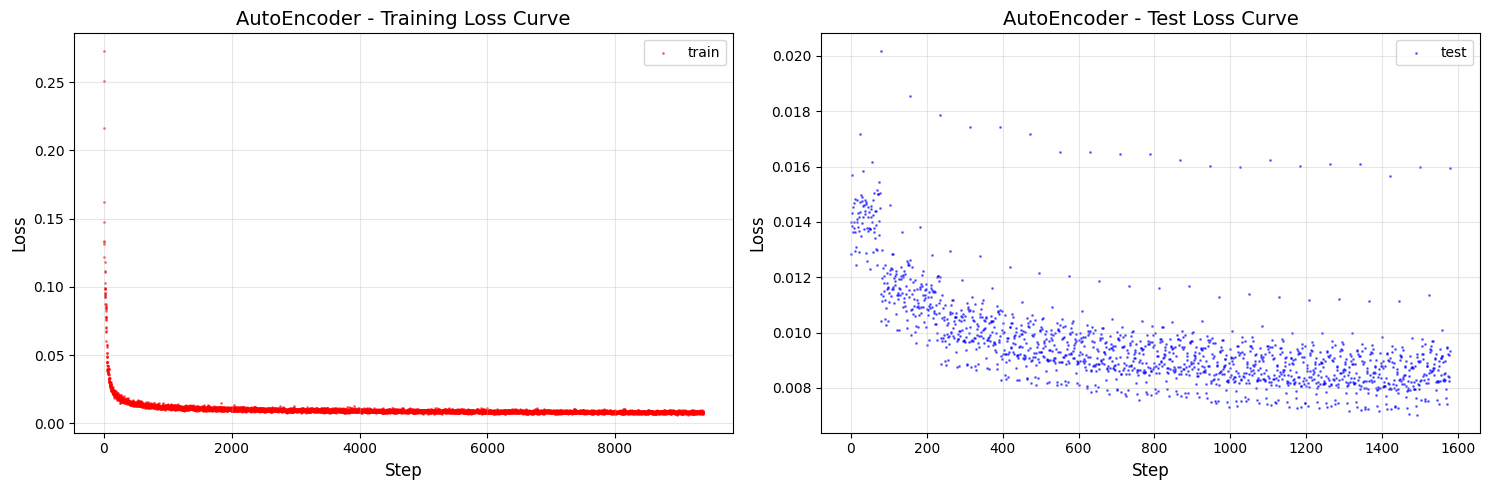

Loss curves saved as loss_curves.png


In [18]:
# Plot training and test loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training loss curve
ax1.scatter(train_steps, train_losses, c='red', alpha=0.5, s=1, label='train')
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('AutoEncoder - Training Loss Curve', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Test loss curve
ax2.scatter(test_steps, test_losses, c='blue', alpha=0.5, s=1, label='test')
ax2.set_xlabel('Step', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('AutoEncoder - Test Loss Curve', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print('Loss curves saved as loss_curves.png')

## Step 5: Inference

Generate reconstructed images using the trained model and display them alongside the original images.

In [19]:
# Get some test images
model.eval()

# Get a batch from test set
dataiter = iter(test_loader)
test_images, test_labels = next(dataiter)
test_images = test_images.to(device)

# Generate reconstructions
with torch.no_grad():
    reconstructed = model(test_images)

# Move to CPU for visualization
test_images = test_images.cpu()
reconstructed = reconstructed.cpu()
test_labels = test_labels.cpu()

# Select 9 images to display
num_images = 9
indices = np.random.choice(len(test_images), num_images, replace=False)

# Fashion MNIST class names
class_names = [
    'T-shirt/top',  # 0
    'Trouser',      # 1
    'Pullover',     # 2
    'Dress',        # 3
    'Coat',         # 4
    'Sandal',       # 5
    'Shirt',        # 6
    'Sneaker',      # 7
    'Bag',          # 8
    'Ankle boot'    # 9
]

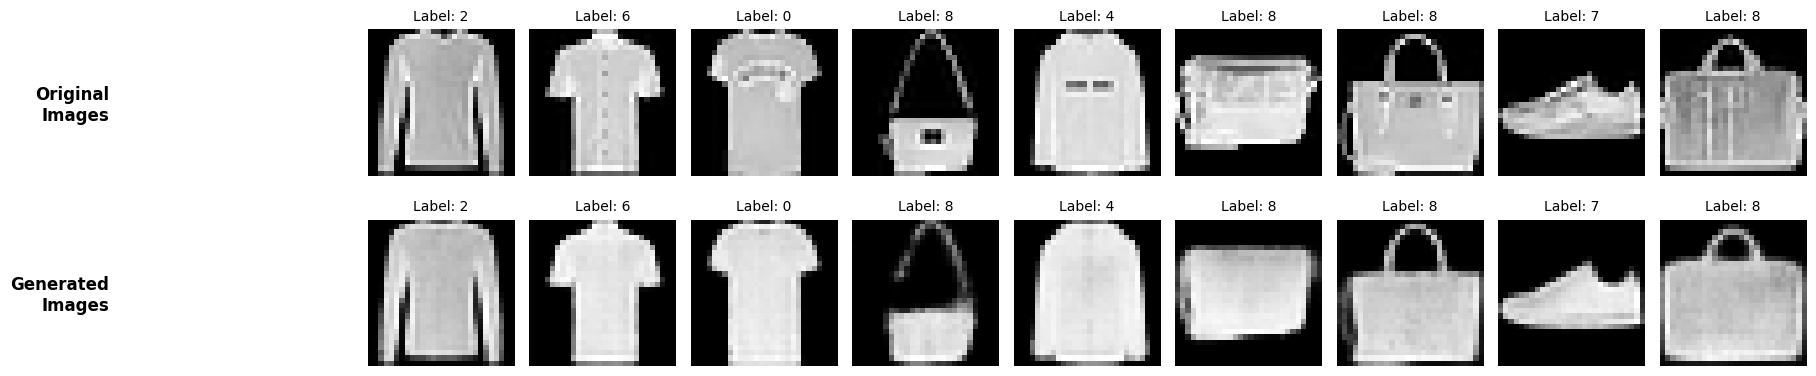

Reconstruction results saved as reconstructed_images.png


In [20]:
# Visualize original and reconstructed images
fig, axes = plt.subplots(2, num_images, figsize=(18, 4))

for i, idx in enumerate(indices):
    # Original images (top row)
    axes[0, i].imshow(test_images[idx].squeeze(), cmap='gray')
    axes[0, i].set_title(f'Label: {test_labels[idx].item()}', fontsize=10)
    axes[0, i].axis('off')

    # Reconstructed images (bottom row)
    axes[1, i].imshow(reconstructed[idx].squeeze(), cmap='gray')
    axes[1, i].set_title(f'Label: {test_labels[idx].item()}', fontsize=10)
    axes[1, i].axis('off')

# Add row labels
axes[0, 0].text(-50, 14, 'Original\nImages', fontsize=12, ha='right', va='center', weight='bold')
axes[1, 0].text(-50, 14, 'Generated\nImages', fontsize=12, ha='right', va='center', weight='bold')

plt.tight_layout()
plt.savefig('reconstructed_images.png', dpi=150, bbox_inches='tight')
plt.show()

print('Reconstruction results saved as reconstructed_images.png')

In [21]:
# Calculate and display reconstruction error
mse_per_image = torch.mean((test_images[indices] - reconstructed[indices]) ** 2, dim=[1, 2, 3])

print('\nReconstruction MSE for displayed images:')
print('=' * 50)
for i, idx in enumerate(indices):
    label = test_labels[idx].item()
    class_name = class_names[label]
    print(f'Image {i+1} - Label: {label} ({class_name}) - MSE: {mse_per_image[i]:.6f}')

print(f'\nAverage MSE: {mse_per_image.mean():.6f}')


Reconstruction MSE for displayed images:
Image 1 - Label: 2 (Pullover) - MSE: 0.005349
Image 2 - Label: 6 (Shirt) - MSE: 0.003742
Image 3 - Label: 0 (T-shirt/top) - MSE: 0.002929
Image 4 - Label: 8 (Bag) - MSE: 0.016292
Image 5 - Label: 4 (Coat) - MSE: 0.006860
Image 6 - Label: 8 (Bag) - MSE: 0.012452
Image 7 - Label: 8 (Bag) - MSE: 0.009504
Image 8 - Label: 7 (Sneaker) - MSE: 0.003589
Image 9 - Label: 8 (Bag) - MSE: 0.011580

Average MSE: 0.008033
